In [53]:
# BAI 457: Final Project 
# Data Visualizations

In [54]:
##### LOAD PACKAGES #####

import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [55]:
##### LOAD DATASET #####

traffic = pd.read_csv("traffic.csv", parse_dates=['Published Date', 'Time_Hour'])

In [56]:
##### CATEGORIZE TRAFFIC INCIDENTS #####

def categorize_issue(issue):
    if pd.isna(issue):
        return 'Other'
    issue = issue.upper()
    if 'FATAL' in issue or 'INJURY' in issue or 'FTSRA' in issue:
        return 'Fatality/Injury'
    elif 'COLLISION' in issue or 'COLLISN' in issue or 'CRASH' in issue or 'ACC' in issue or 'AUTO/ PED' in issue:
        return 'Collision'
    elif 'HAZD' in issue or 'HAZARD' in issue or 'DEBRIS' in issue or 'OBSTRUCT' in issue or 'BLOCKED' in issue or 'LIVESTOCK' in issue or 'HIGH WATER' in issue or 'ICY' in issue:
        return 'Hazard/Obstruction'
    elif 'STALLED' in issue or 'VEHICLE FIRE' in issue:
        return 'Vehicle Issue'
    else:
        return 'Other'

# Apply to your data
traffic['Issue_Category'] = traffic['Issue Reported'].apply(categorize_issue)

# Preview counts
traffic['Issue_Category'].value_counts()


Collision             213041
Hazard/Obstruction    168347
Vehicle Issue          19602
Fatality/Injury        11192
Other                   6268
Name: Issue_Category, dtype: int64

In [57]:
##### K-MEANS CLUSTERING #####

traffic['Issue_Category'] = traffic['Issue Reported'].apply(categorize_issue)
traffic['Hour'] = traffic['Time_Hour'].dt.hour
collisions = traffic[traffic['Issue_Category'] == 'Collision'].copy()

### CLUSTERING

clustering_data = collisions[['Volume', 'Speed', 'Hour']].dropna()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)
kmeans = KMeans(n_clusters=3, random_state=42)
clustering_data['Cluster'] = kmeans.fit_predict(scaled_data)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centroids = pd.DataFrame(centers, columns=['Volume', 'Speed', 'Hour'])
centroids['Cluster'] = centroids.index.astype(str)
print("Cluster Centers:\n", centroids)
cluster_labels = {
    '0': 'High Congestion',
    '1': 'High Speed / Low Volume',
    '2': 'Rush Hour Flow'
}
clustering_data['Cluster'] = clustering_data['Cluster'].astype(str)
clustering_data['Cluster_Name'] = clustering_data['Cluster'].map(cluster_labels)

fig = px.scatter(
    clustering_data.sample(n=3000, random_state=1),
    x='Volume',
    y='Speed',
    color='Cluster_Name',
    title="Traffic Condition Clusters (Named)",
    labels={'Volume': 'Traffic Volume', 'Speed': 'Traffic Speed'},
    opacity=0.5
)
fig.show() 

### INCIDENT COUNT PER CLUSTER 

collisions_cleaned = collisions[['Volume', 'Speed', 'Hour', 'Traffic Report ID']].dropna()
collisions_cleaned = collisions_cleaned.copy() 
collisions_cleaned['Cluster'] = kmeans.predict(scaler.transform(collisions_cleaned[['Volume', 'Speed', 'Hour']]))
collisions_cleaned['Cluster'] = collisions_cleaned['Cluster'].astype(str)
collisions_cleaned['Cluster_Name'] = collisions_cleaned['Cluster'].map(cluster_labels)

incident_counts = collisions_cleaned['Cluster_Name'].value_counts().reset_index()
incident_counts.columns = ['Cluster_Name', 'Incident Count']
print(incident_counts)

fig_incidents = px.bar(
    incident_counts,
    x='Cluster_Name',
    y='Incident Count',
    title='Incident Count per Traffic Cluster',
    text='Incident Count',
    color='Cluster_Name'
)
fig_incidents.update_layout(showlegend=False)
fig_incidents.show()

Cluster Centers:
        Volume      Speed       Hour Cluster
0  107.203528  37.064131  15.466552       0
1   22.353268  51.887231   5.484580       1
2   74.470187  45.533668  18.585769       2


              Cluster_Name  Incident Count
0          High Congestion           28581
1           Rush Hour Flow           22950
2  High Speed / Low Volume           19880


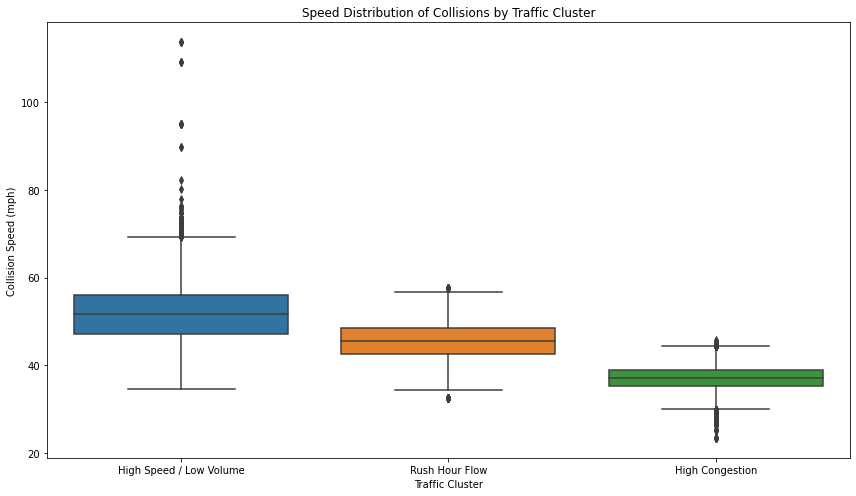

In [58]:
##### SPEED DISTRIBUTION OF COLLISIONS BY TRAFFIC CLUSTER ##### 

# set order of clusters
cluster_order = ['High Speed / Low Volume', 'Rush Hour Flow', 'High Congestion']

# convert to categorical with the custom order
collisions_cleaned['Cluster_Name'] = pd.Categorical(
    collisions_cleaned['Cluster_Name'],
    categories=cluster_order,
    ordered=True
)

plt.figure(figsize=(12, 7))
sns.boxplot(data=collisions_cleaned, x='Cluster_Name', y='Speed')
plt.title("Speed Distribution of Collisions by Traffic Cluster")
plt.xlabel("Traffic Cluster")
plt.ylabel("Collision Speed (mph)")
plt.xticks()
plt.tight_layout()
plt.show()

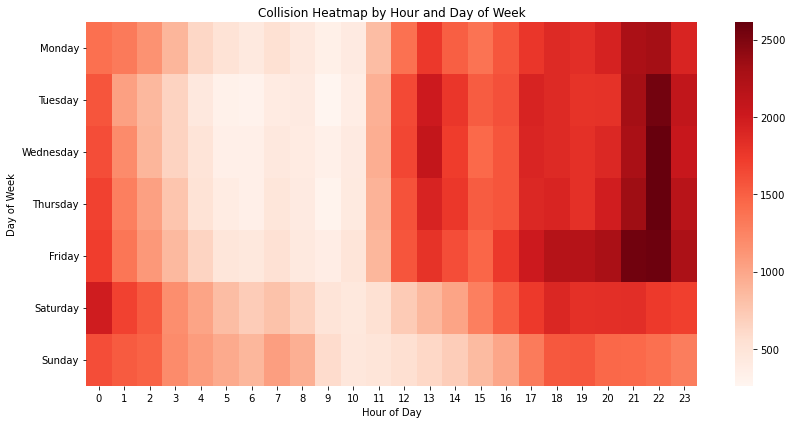

In [59]:
##### COLLISION BY HOUR AND DAY OF THE WEEK #####

# define order for weekdays
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# assign ordered category
collisions['Weekday'] = pd.Categorical(
    collisions['Time_Hour'].dt.day_name(),
    categories=ordered_days,
    ordered=True
)
collisions['Hour'] = collisions['Time_Hour'].dt.hour

heatmap_data = (
    collisions.groupby(['Weekday', 'Hour'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Reds')
plt.title("Collision Heatmap by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

In [47]:
##### COLLISION FREQUENCY BY HOUR AND CLUSTER #####

# extract hour and cluster info
time_cluster_counts = (
    collisions_cleaned
    .groupby(['Hour', 'Cluster_Name'])
    .size()
    .reset_index(name='Count')
)

fig3 = px.line(
    time_cluster_counts,
    x='Hour',
    y='Count',
    color='Cluster_Name',
    markers=True,
    title='Collision Frequency by Hour and Traffic Cluster',
    labels={'Count': 'Number of Collisions'}
)
fig3.show()